# Import Modules

In [11]:
import matplotlib as mpl 
mpl.use('TkAgg') 
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

# URL for death dating
deaths_csv = 'https://bit.ly/2z2XdkQ'

# Import deaths CV
df = pd.read_csv(deaths_csv)

df.head(3)

,Province/State,Country/Region,Lat,Long,Date,Value,ISO 3166-1 Alpha 3-Codes,Region Code,Sub-region Code,Intermediate Region Code
0,#adm1+name,#country+name,#geo+lat,#geo+lon,#date,#affected+infected+value+num,#country+code,#region+main+code,#region+sub+code,#region+intermediate+code
1,NaN,Afghanistan,33.0,65.0,2020-05-02,72,AFG,142,34,NaN
2,NaN,Afghanistan,33.0,65.0,2020-05-01,68,AFG,142,34,NaN


# Clean Data and Calculate Metrics

In [12]:
# Drop the meta-data row
df.drop(0, inplace = True)

# Convert numbers to floats
df['Value'] = pd.to_numeric(df['Value'])

We want to plot a line for each country, each day. However, some of the data is broken down into provinces within countries.

In [13]:
df[(df['Country/Region'] == 'China') & (df['Date'] == '2020-01-22')].sample(3)

,Province/State,Country/Region,Lat,Long,Date,Value,ISO 3166-1 Alpha 3-Codes,Region Code,Sub-region Code,Intermediate Region Code
6732,Hainan,China,19.1959,109.7453,2020-01-22,0,CHN,142,30,NaN
7956,Macau,China,22.1667,113.55,2020-01-22,0,MAC,142,30,NaN
7650,Jiangxi,China,27.614,115.7221,2020-01-22,0,CHN,142,30,NaN


To deal with this, we peform a groupby calculation over the 'Country/Region' and 'Date' columns.

In [14]:
df = df.groupby(['Country/Region','Date']).sum()['Value'].reset_index()
df.sample(3)

,Country/Region,Date,Value
14217,Russia,2020-03-01,0
15629,Slovenia,2020-02-14,0
8040,Iceland,2020-04-15,8


In [15]:
# Calculating Daily Increase

countries = df['Country/Region'].unique() # Get a total list of countries
chart_data = pd.DataFrame() # Create an empty dataframe to store our calculations

for c in countries:

  #Create a temp dataframe with just the country we are currently working on
  temp = df[df['Country/Region'] == c]
  
  # Get rid of all records for country c with zero deaths (ie. Take only data from the first day of deaths).
  temp = temp[temp.Value >=1].reset_index()
  
  # Since the 'value' column records total deaths. We need to iterate through each date and 
  # calculate the number of deaths on that particular day
  for key, row in temp.iterrows():
    
    if key == 0:
      # If working on the first record, 
      temp.loc[key,'daily_increase'] = temp.loc[key,'Value']
      temp.loc[key,'days_past_since_first_death'] = int(0)
    else:
      # For every subsequent record, compare the total deaths ('Value') with the total deaths on the 
      # previous data to calculate the deaths on that particular day.
      temp.loc[key,'daily_increase'] = temp.loc[key,'Value'] - temp.loc[key-1, 'Value']
      temp.loc[key,'days_past_since_first_death'] = int(temp.loc[key-1,'days_past_since_first_death'] + 1)
      
  chart_data = chart_data.append(temp)

/Users/danielthomas/anaconda3/envs/tboc/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


# Plotting the Data

In [16]:
# We set up some parameters

no_total_countries = 35 # Total number of countries to plot
no_highlighted_countries = 10 # Total number of countries to highlight  
annotate = True

# We work out the top 35 countries in terms of deaths
countries_to_plot = chart_data.groupby(['Country/Region']).max().reset_index() # Calculate maximum daily deahts by country
countries_to_plot = countries_to_plot.sort_values('daily_increase', ascending = False) # Sort table by total deaths
countries_to_plot = list(countries_to_plot.head(no_total_countries)['Country/Region']) # Create a list of countries with the most deaths. These will be plotted

### Function to Plot Lines
The function below first calculates a moving averages to smoothen the line. It then also calculate a Cublic Spline
function to remove all jagged edges and create a nicer curvier line.

In [17]:
def plot_country(c, color, linewidth, annotate = False, add_border = False):

  # Create a temporary dataframe called cd and set x, y columns
  cd = chart_data[chart_data['Country/Region'] == c]
  y = cd['daily_increase']
  x = cd['days_past_since_first_death']

  # Calculate moving averages to make a smoother graph
  mov_y = cd['daily_increase'].rolling(window = 10).mean() # Get rolling y vals
  mov_y = mov_y.fillna(0)

  # Calculate Cublic Spline curve to remove jagged edges and create an even smoother graph
  x_smooth = np.linspace(x.min(), x.max(), 500) # Split x_axis up into 500 points
  spl = CubicSpline(x, mov_y) # Generate spline function
  y_smooth = spl(x_smooth) # Calculate new smooth y points
  
  # We use this to plot a slighty larger white line underneath our coloured line. 
  # This has the effect of a line edge
  if add_border == True:
    ax.plot(x_smooth, y_smooth,
        color = 'white', 
        linewidth = linewidth + 2,
        label = i)
  
  # Now plot the actual line
  ax.plot(x_smooth, y_smooth,
          color = color, 
          linewidth = linewidth,
          label = i)

  # We append the name location and name of the country to a list of lists which we will 
  # plot in the next sections
  if annotate == True:
    annotate_list.append([x_smooth[-1], y_smooth[-1], i])

### Plotting

6

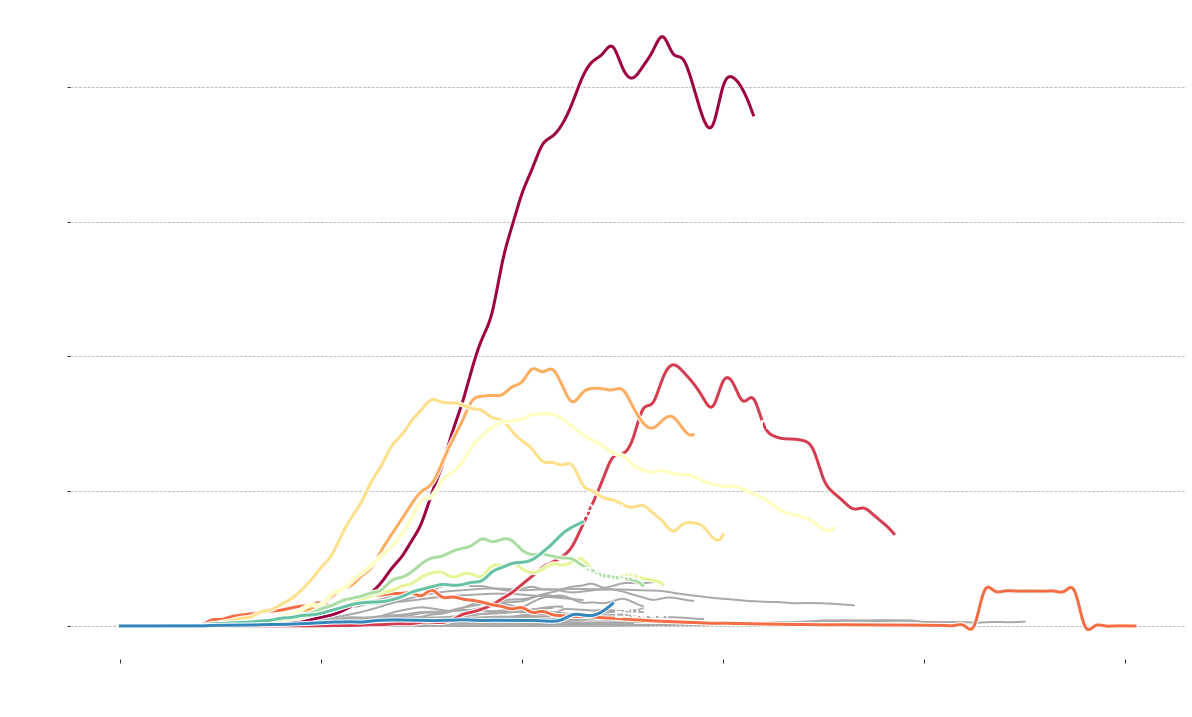

In [19]:
from scipy.interpolate import CubicSpline
from random import random
from adjustText import adjust_text

fig, ax = plt.subplots(figsize=[20,12])

annotate_list = []
count = 0 # Counter required for plotting colourmaps

# ===================== Plot =====================

# Plot grey lines
for i in countries_to_plot[no_highlighted_countries:]: 
  plot_country(i, 'darkgrey', 2)

# Plot highlighted countries
for i in countries_to_plot[:no_highlighted_countries]:
  colour = plt.cm.Spectral(count/no_highlighted_countries)
  plot_country(i, colour, 3, annotate = True, add_border = True)
  count = count + 1

#==================== AXIS AND STLYE =====================
  
ax.yaxis.grid(linestyle = '--')

ax.tick_params(axis='both', which='major', labelsize=15, pad=2)
ax.tick_params(axis='x', which='major', labelsize=15, pad=2)

ax.set_ylabel('Deaths Per Day',
              fontsize = 15,
              color = 'white')

ax.set_xlabel('Days Since First Death',
              fontsize = 15, 
              color = 'white',
              labelpad = 15)

plt.yticks(color = 'white')
plt.xticks(color = 'white', rotation = 0)
ax.set_frame_on(False)

# ===================== Annotate with AdjustText =====================

texts = []
for i in annotate_list:
  texts.append(ax.text(i[0], i[1], i[2],
             color = 'white', size = 17, fontfamily = 'DIN Alternate', fontstyle = 'oblique'))

# We use adjust_text to adjust texts which overlap
adjust_text(texts, ha = 'left', text_from_points = True, expand_text = (0,0.1))